In [3]:
# Pissible need package install if needed

#Used for import function from other ipynb file
#pip install ipynb

#Install pytorch
#pip install pytorch

In [1]:
import torch

In [88]:
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import argparse
from torchvision.utils import save_image
from ipynb.fs.full.utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, DiffAugment, ParamDiffAug
import matplotlib.pyplot as plt

In [8]:
mnist_data = "mnist_data"
mnist_result = "mnist_result"

if not os.path.exists(mnist_data):
    os.mkdir(mnist_data)

if not os.path.exists(mnist_result):
    os.mkdir(mnist_result)

cifar_data = "cifar_data"
cifar_result = "cifar_result"

if not os.path.exists(cifar_data):
    os.mkdir(cifar_data)

if not os.path.exists(cifar_result):
    os.mkdir(cifar_result)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [127]:
#load data
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)

In [128]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

In [129]:
images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

In [130]:
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [131]:
for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c])))

class c = 0: 5923 real images
class c = 1: 6742 real images
class c = 2: 5958 real images
class c = 3: 6131 real images
class c = 4: 5842 real images
class c = 5: 5421 real images
class c = 6: 5918 real images
class c = 7: 6265 real images
class c = 8: 5851 real images
class c = 9: 5949 real images


# 2 a

In [132]:
#Get the net
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

In [133]:
#first train with dataset
def epoch(mode, dataloader, net, optimizer, criterion,device):
    loss_avg, acc_avg, num_exp = 0,0,0
    net = net.to(device)
    criterion = criterion.to(device)
    if mode == 'train':
        net.train()
    else:
        net.eval()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10)
    for i_batch,datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]
        
        output = net(img)
        loss = criterion(output,lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
        
        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b
        
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
    loss_avg /= num_exp
    acc_avg /= num_exp
    
    return loss_avg, acc_avg


def train_with_dataset(net, images_train, labels_train, testloader,device):
    net = net.to(device)
    images_train = images_train.to(device)
    labels_train = labels_train.to(device)
    lr = 0.01
    Epoch = 20
    optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum = 0.9, weight_decay = 0.0005)
    criterion = nn.CrossEntropyLoss().to(device)
    dst_train = TensorDataset(images_train,labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size = 256, shuffle = True, num_workers = 0)
    for ep in range(Epoch):
        loss_train, acc_train = epoch('train',trainloader, net, optimizer, criterion, device)
        print("loss train: {}, acc_train: {}".format(loss_train, acc_train))
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, device)
    return acc_train, acc_test


In [134]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [135]:
acc_train,acc_test = train_with_dataset(ConvNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 0.2813450437903404, acc_train: 0.9336333333333333
loss train: 0.07174733942349752, acc_train: 0.98135
loss train: 0.052296118489901226, acc_train: 0.98575
loss train: 0.04291417036851247, acc_train: 0.9884
loss train: 0.0410687867924571, acc_train: 0.9888
loss train: 0.034195215247074764, acc_train: 0.9909
loss train: 0.030782918323079746, acc_train: 0.9917333333333334
loss train: 0.02806105834444364, acc_train: 0.99255
loss train: 0.025210503802696863, acc_train: 0.9931833333333333
loss train: 0.02548946618984143, acc_train: 0.9929166666666667
loss train: 0.022979000716408095, acc_train: 0.9939
loss train: 0.022479002445936203, acc_train: 0.9939333333333333
loss train: 0.020719313219189645, acc_train: 0.9946
loss train: 0.020362074918548266, acc_train: 0.9947333333333334
loss train: 0.018947665725151698, acc_train: 0.995
loss train: 0.018022723152240117, acc_train: 0.9952166666666666
loss train: 0.015779156557718912, acc_train: 0.9962666666666666
loss train: 0.015445921871

# 2 b

In [136]:
K = 100
T = 10
learningRateCondensedSamples = 0.1
numberOptimizationSteps = 1
learningRateModel = 0.01
numberOfOptimizationSteps = 50
ipc = 10
miniBatchSize = 256

In [137]:
#initialize the synthetic data
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


C:\Users\alanw\AppData\Local\Temp\ipykernel_4616\3204847356.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [138]:
def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

In [139]:
for c in range(num_classes):
    image_syn.data[c*ipc:(c+1)*ipc] = get_images(c, ipc).detach().data

In [140]:
#Train
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)

In [141]:
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

In [142]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

In [143]:
for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)
print('loss = %.4f' % loss_avg)
    

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [144]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------MNIST result --------------------------------------------------------------------
mnist_images_sync, mnist_labels_sync = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync, mnist_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3500776290893555, acc_train: 0.07
loss train: 2.2080719470977783, acc_train: 0.25
loss train: 2.039961099624634, acc_train: 0.5
loss train: 1.867619514465332, acc_train: 0.55
loss train: 1.6745489835739136, acc_train: 0.78
loss train: 1.4927163124084473, acc_train: 0.9
loss train: 1.3337702751159668, acc_train: 0.84
loss train: 1.1803957223892212, acc_train: 0.85
loss train: 1.0338361263275146, acc_train: 0.95
loss train: 0.9048736691474915, acc_train: 0.97
loss train: 0.7922200560569763, acc_train: 0.96
loss train: 0.6895557641983032, acc_train: 0.97
loss train: 0.5975948572158813, acc_train: 0.99
loss train: 0.5200803279876709, acc_train: 0.99
loss train: 0.4553050100803375, acc_train: 0.99
loss train: 0.3994424343109131, acc_train: 0.99
loss train: 0.35101428627967834, acc_train: 0.99
loss train: 0.30995237827301025, acc_train: 1.0
loss train: 0.2750681936740875, acc_train: 1.0
loss train: 0.24459825456142426, acc_train: 1.0
Acc train 1.0, Acc test 0.8817


# 1 c

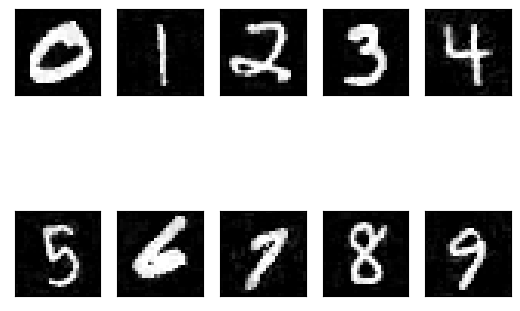

In [145]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [146]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)

Files already downloaded and verified
Files already downloaded and verified


In [147]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

In [148]:
images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

In [149]:
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [150]:
#base line
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [151]:
acc_train,acc_test = train_with_dataset(ConvNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 1.5186413581085205, acc_train: 0.47404
loss train: 1.0999914757919311, acc_train: 0.62014
loss train: 0.9484160287857055, acc_train: 0.67376
loss train: 0.8601027767562867, acc_train: 0.70638
loss train: 0.7801035723495483, acc_train: 0.73186
loss train: 0.731474999256134, acc_train: 0.75032
loss train: 0.6833760660171508, acc_train: 0.76794
loss train: 0.6455917256736755, acc_train: 0.78226
loss train: 0.625276674041748, acc_train: 0.78964
loss train: 0.5872163279914856, acc_train: 0.8023
loss train: 0.5616978243827819, acc_train: 0.81006
loss train: 0.5249532890224456, acc_train: 0.82452
loss train: 0.5111388612556458, acc_train: 0.82762
loss train: 0.4778921584510803, acc_train: 0.84074
loss train: 0.4637912337112427, acc_train: 0.8458
loss train: 0.44275431280136107, acc_train: 0.85252
loss train: 0.41493288507461545, acc_train: 0.8647
loss train: 0.4010163061618805, acc_train: 0.86872
loss train: 0.3673111338710785, acc_train: 0.88172
loss train: 0.35732473117828367, a

In [152]:
#initialize syn image
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
for c in range(num_classes):
    image_syn.data[c*ipc:(c+1)*ipc] = get_images(c, ipc).detach().data

C:\Users\alanw\AppData\Local\Temp\ipykernel_4616\3004736898.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [153]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)

In [154]:
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

In [155]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

In [156]:
for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [157]:
print('loss = %.4f' % loss_avg)

loss = 92.3808


In [159]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------CIFAR result --------------------------------------------------------------------
cifar_images_sync, cifar_labels_sync = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync, cifar_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.337019920349121, acc_train: 0.11
loss train: 2.2376081943511963, acc_train: 0.19
loss train: 2.0888168811798096, acc_train: 0.44
loss train: 1.9432306289672852, acc_train: 0.47
loss train: 1.8072222471237183, acc_train: 0.52
loss train: 1.6682066917419434, acc_train: 0.62
loss train: 1.530117392539978, acc_train: 0.74
loss train: 1.4025686979293823, acc_train: 0.78
loss train: 1.285974383354187, acc_train: 0.85
loss train: 1.176071047782898, acc_train: 0.87
loss train: 1.0721518993377686, acc_train: 0.89
loss train: 0.9761106967926025, acc_train: 0.9
loss train: 0.8879815936088562, acc_train: 0.94
loss train: 0.8073111176490784, acc_train: 0.96
loss train: 0.7314158082008362, acc_train: 0.97
loss train: 0.6606225371360779, acc_train: 0.99
loss train: 0.5956206321716309, acc_train: 0.99
loss train: 0.5372591614723206, acc_train: 0.99
loss train: 0.4856618046760559, acc_train: 0.99
loss train: 0.43952298164367676, acc_train: 0.99
Acc train 0.99, Acc test 0.3355


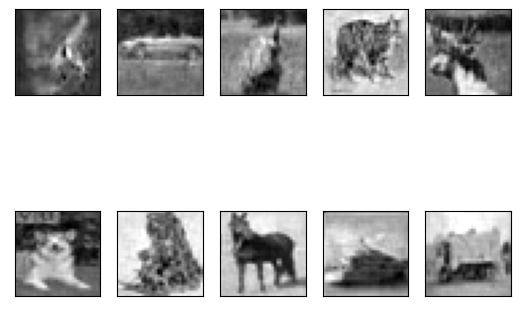

In [161]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 2 d

In [162]:
# ------------------------MNIST initialize with noisy-----------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [163]:
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

C:\Users\alanw\AppData\Local\Temp\ipykernel_4616\2139612781.py:2: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [164]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [165]:
print('loss = %.4f' % loss_avg)

loss = 109.3868


In [166]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------MNIST result --------------------------------------------------------------------
mnist_images_sync_noisy, mnist_labels_sync_noisy = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync_noisy, mnist_labels_sync_noisy, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3481152057647705, acc_train: 0.07
loss train: 2.2511353492736816, acc_train: 0.22
loss train: 2.153642416000366, acc_train: 0.35
loss train: 2.0423824787139893, acc_train: 0.32
loss train: 1.890242338180542, acc_train: 0.74
loss train: 1.7436752319335938, acc_train: 0.86
loss train: 1.6223092079162598, acc_train: 0.78
loss train: 1.4973660707473755, acc_train: 0.8
loss train: 1.363615870475769, acc_train: 0.91
loss train: 1.2427769899368286, acc_train: 0.94
loss train: 1.1385847330093384, acc_train: 0.96
loss train: 1.0379784107208252, acc_train: 0.96
loss train: 0.9397436380386353, acc_train: 0.96
loss train: 0.8526791334152222, acc_train: 0.96
loss train: 0.7769293785095215, acc_train: 0.95
loss train: 0.7068271040916443, acc_train: 0.96
loss train: 0.6407475471496582, acc_train: 0.96
loss train: 0.5807604789733887, acc_train: 0.98
loss train: 0.5276836156845093, acc_train: 0.98
loss train: 0.4803120493888855, acc_train: 0.98
Acc train 0.98, Acc test 0.7776


In [167]:
# ------------------------CIFAR initialize with noisy-----------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

Files already downloaded and verified
Files already downloaded and verified


In [168]:
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

C:\Users\alanw\AppData\Local\Temp\ipykernel_4616\2139612781.py:2: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [169]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [170]:
print('loss = %.4f' % loss_avg)

loss = 146.5663


In [171]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------CIFAR result --------------------------------------------------------------------
cifar_images_sync_noisy, cifar_labels_sync_noisy = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync_noisy, cifar_labels_sync_noisy, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3759701251983643, acc_train: 0.08
loss train: 2.2860002517700195, acc_train: 0.06
loss train: 2.1635663509368896, acc_train: 0.29
loss train: 2.0260558128356934, acc_train: 0.45
loss train: 1.8572895526885986, acc_train: 0.61
loss train: 1.662672758102417, acc_train: 0.91
loss train: 1.472883939743042, acc_train: 0.98
loss train: 1.3037686347961426, acc_train: 0.98
loss train: 1.1455719470977783, acc_train: 0.98
loss train: 0.9924879670143127, acc_train: 0.98
loss train: 0.8531034588813782, acc_train: 1.0
loss train: 0.7349989414215088, acc_train: 1.0
loss train: 0.6365845203399658, acc_train: 1.0
loss train: 0.5522715449333191, acc_train: 1.0
loss train: 0.47850748896598816, acc_train: 1.0
loss train: 0.41478225588798523, acc_train: 1.0
loss train: 0.36086300015449524, acc_train: 1.0
loss train: 0.31568068265914917, acc_train: 1.0
loss train: 0.2776459753513336, acc_train: 1.0
loss train: 0.24533237516880035, acc_train: 1.0
Acc train 1.0, Acc test 0.2639


# 2 e

In [172]:
# ------------------------MNIST------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)

ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync, mnist_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.340663433074951, acc_train: 0.1
loss train: 2.1855263710021973, acc_train: 0.3
loss train: 2.026710271835327, acc_train: 0.42
loss train: 1.8519154787063599, acc_train: 0.44
loss train: 1.6452915668487549, acc_train: 0.81
loss train: 1.4713256359100342, acc_train: 0.82
loss train: 1.3256127834320068, acc_train: 0.86
loss train: 1.1728260517120361, acc_train: 0.88
loss train: 1.0262266397476196, acc_train: 0.94
loss train: 0.9051598906517029, acc_train: 0.95
loss train: 0.7985687851905823, acc_train: 0.97
loss train: 0.6984975934028625, acc_train: 0.98
loss train: 0.6097496747970581, acc_train: 0.99
loss train: 0.5345929861068726, acc_train: 0.98
loss train: 0.4691038131713867, acc_train: 0.98
loss train: 0.41178253293037415, acc_train: 0.98
loss train: 0.3629816770553589, acc_train: 0.99
loss train: 0.3212772309780121, acc_train: 0.99
loss train: 0.28493401408195496, acc_train: 0.99
loss train: 0.25335830450057983, acc_train: 0.99
Acc train 0.99, Acc test 0.884


In [173]:
#-----------------------CIFAR Result------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)

ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync, cifar_labels_sync, testloader, device)

print("Acc train {}, Acc test {}".format(acc_train, acc_test))

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: Given groups=1, weight of size [128, 3, 3, 3], expected input[100, 1, 28, 28] to have 3 channels, but got 1 channels instead